## Initial Commands

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [10]:
!pwd

/home/paperspace/fastai/courses/dl1


In [5]:
PATH = '/home/paperspace/data/cancer_detection'
sz=224
arch=resnext101_64
bs=256

In [6]:
label_csv = f'{PATH}/train_labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n, val_pct=0.15) # random 20% data for validation set

In [7]:
ls {PATH}

models/                    test/     tmp/    train_labels.csv*
sample_submission.csv.zip  test.zip  train/  train.zip


In [8]:
label_df = pd.read_csv(f"{PATH}/train_labels.csv")
label_df.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [9]:
label_df.pivot_table(index = 'label', aggfunc = len).sort_values('id', ascending = False)

,id
label,
0,130908
1,89117


## Plotting Sample Images

In [10]:
files = os.listdir(f'{PATH}/train')[:10]
list_paths = [f"{PATH}/train/{files[i]}" for i in range(len(files))]
list_paths

['/home/paperspace/data/cancer_detection/train/19960cfe73fd1cdea6ea8b095daf127cf97f606d.tif',
 '/home/paperspace/data/cancer_detection/train/4bb590dd2da8fc0ef50b1f5b6e0ff76a4c16022d.tif',
 '/home/paperspace/data/cancer_detection/train/9b4acb859bdfff8b555bff5f160870d24190fa3a.tif',
 '/home/paperspace/data/cancer_detection/train/18d583764b1b5e967aec31a8ac6ec8807a5a0f10.tif',
 '/home/paperspace/data/cancer_detection/train/48080288abad3f0fd829c1cfb8b663d3a37274b8.tif',
 '/home/paperspace/data/cancer_detection/train/f4cdc34e3cfe8eb51d63fb0dac79e650a8d22dba.tif',
 '/home/paperspace/data/cancer_detection/train/a146261f5785f7c2a37903a509d23dc126168268.tif',
 '/home/paperspace/data/cancer_detection/train/5b2ba98a48fd754b021e44e90da30123b297ded3.tif',
 '/home/paperspace/data/cancer_detection/train/417d9bdeac7d17480ac956c82ea214e097b8997c.tif',
 '/home/paperspace/data/cancer_detection/train/980c1b1fc7ae8c8a988c5f777b375a3de7a94a3b.tif']

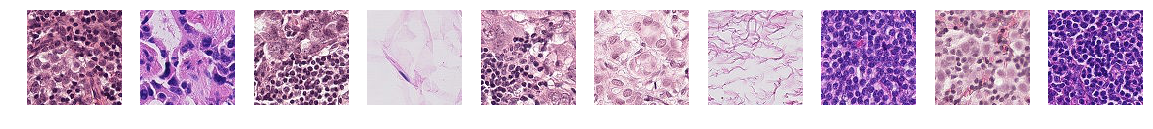

In [12]:
plots_from_files(list_paths, figsize = (20,15))

## Building the Deep Learning Model 

**Get Data in to the data model object**

In [11]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, suffix = '.tif',
                                        val_idxs = val_idxs, test_name = 'test')
    return data

In [13]:
data=get_data(128)

**Initiate learner** <br>
In our case, the learner architecture is Resnet33 to start with. 

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

**Find best Learning Rate** <br>
Using lr_find(), we are able to find the best learning rate, which is the most suitable for our problem. 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 2347/2923 [00:44<00:10, 53.12it/s, loss=1.19] 

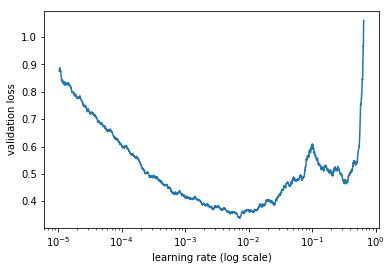

In [16]:
lrf=learn.lr_find()
learn.sched.plot()

In [17]:
lr = 0.01

It seems like without taking any rist, 0.001 seems to be a suitable learning rate. Choosing a learning rate that is smaller means the model will take longer to define the weights. 

**Training the last layer of the learn object** <br>
Let's train the last layer of the learn architecture which is precomputed. 

In [18]:
learn.fit(lr, n_cycle = 3, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  8%|▊         | 225/2923 [00:04<00:56, 47.86it/s, loss=0.459]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.292136   0.27374    0.885465  
    1      0.296432   0.264091   0.89098                       
    2      0.295187   0.253552   0.894222                      
    3      0.297765   0.252895   0.894101                      
    4      0.264019   0.244505   0.89807                       
    5      0.251487   0.238958   0.901615                      
    6      0.258104   0.2374     0.901645                      



[array([ 0.2374]), 0.9016453050065899]

In [19]:
learn.save(f'cancer_{sz}')
learn.load(f'cancer_{sz}')

After training the top-layer, it we will now train the earlier layers. Since the images are very different from image net, earlier layers will have a higher learning rate and later layers. 

In [20]:
lrs = np.array([lr/9,lr/3,lr])

In [21]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.27971    0.241264   0.900494  
    1      0.286173   0.248378   0.896676                      
    2      0.266726   0.237763   0.900948                      
    3      0.272129   0.243828   0.899736                      
    4      0.257013   0.236283   0.903554                      
    5      0.270163   0.232879   0.904433                      
    6      0.263996   0.233704   0.90413                       



[array([ 0.2337]), 0.90412992758775912]

In [22]:
learn.save(f'cancer_unfreezed_once_{sz}')
learn.load(f'cancer_unfreezed_once_{sz}')

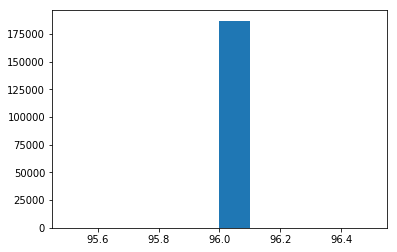

In [23]:
size_d = {k: PIL.Image.open(PATH + '/' + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
plt.hist(row_sz);

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
sz=256
learn.set_data(get_data(sz))
learn.freeze()

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.272185   0.255106   0.895525  
    1      0.27627    0.242325   0.902857                      
    2      0.268607   0.235478   0.907008                      
    3      0.273093   0.233394   0.907008                      
    4      0.25006    0.225799   0.908978                      
Validation:  45%|████▍     | 232/516 [04:10<05:06,  1.08s/it]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      0.25234    0.22387    0.910402                      



[array([ 0.22387]), 0.91040208466438854]

In [25]:
# learn.save(f'cancer_after_unfreeze_{sz}')

In [15]:
learn.load(f'cancer_after_unfreeze_{sz}')

In [16]:
learn

Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): Sequential(
      (0): LambdaMap(
        (0): Sequential(
          (0): Sequential(
            (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (2): ReLU()
            (3): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (5): ReLU()
          )
          (1): Conv2d (256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): Sequential(
          (0): Conv2d (64, 256, kernel_size=(1, 1)

In [17]:
learn.precompute = False

In [18]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.237902   0.21949    0.913462  
    1      0.246636   0.219373   0.91319                       
    2      0.252288   0.219813   0.912099                      
    3      0.239537   0.215606   0.91522                       
    4      0.239617   0.215524   0.914523                      



[array([ 0.21552]), 0.91452292216400977]

In [19]:
learn.save(f'cancer_precomputed_false_{sz}')
learn.load(f'cancer_precomputed_false_{sz}')

In [20]:
log_preds, y = learn.TTA()

In [28]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y)

0.92703693603611792

In [29]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[18846   794]
 [ 1614 11749]]


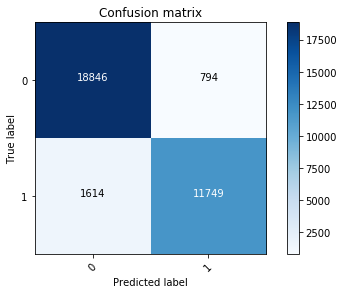

In [30]:
plot_confusion_matrix(cm, data.classes)

In [31]:
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,\
                            roc_curve,roc_auc_score,classification_report

AUC SCORE: 0.919395519866


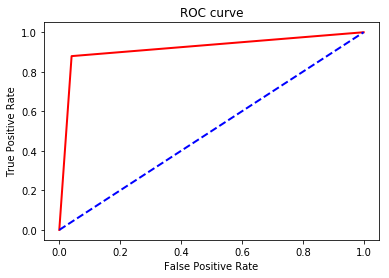

In [33]:
fpr, tpr, threshold = roc_curve(y, preds)
auc_score = roc_auc_score(y, preds)
print("AUC SCORE:", auc_score)
plt.figure()
plt.plot(fpr, tpr, color='red',
lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

**GETTING PREDICTIONS FOR TEST DATA**

In [ ]:
log_preds, y = learn.TTA(is_test = True)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y)